In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

In [2]:
import torchvision.datasets

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADER

In [4]:
root = 'D:\\Spring 19\\ECE 285\\Project\\PascalVOC2012'

In [5]:
import os
import sys
import tarfile
import collections

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

from PIL import Image


class VOCDetection(td.Dataset):
    """`Pascal VOC <http://host.robots.ox.ac.uk/pascal/VOC/>`_ Detection Dataset.

    Args:
        root (string): Root directory of the VOC Dataset.
        year (string, optional): The dataset year, supports years 2007 to 2012.
        image_set (string, optional): Select the image_set to use, ``train``, ``trainval`` or ``val``
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
            (default: alphabetic indexing of VOC's 20 classes).
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, required): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self,
                 root,
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None,
                 #transforms=None,
                 image_size=(416, 416)):
        super(VOCDetection, self).__init__()
        self.year = year
        self.image_set = image_set 
        #self.transforms = transforms
        self.image_size = image_size
        
        image_dir = os.path.join(root, 'JPEGImages')
        annotation_dir = os.path.join(root, 'Annotations')
        splits_dir = os.path.join(root, 'ImageSets/Main')
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        if not os.path.exists(split_f):
            raise ValueError(
                'Wrong image_set entered! Please use image_set="train" '
                'or image_set="trainval" or image_set="val" or a valid'
                'image_set from the VOC ImageSets/Main folder.')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())
        
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size), \
                                tv.transforms.ToTensor(), tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
        img = transform(img)

    
        return img, target


    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [7]:
train_set = VOCDetection(root, year='2012', image_set='train')

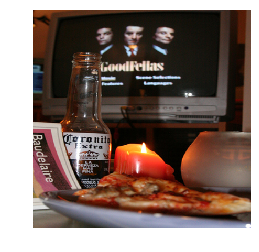

In [8]:
%matplotlib inline
x = train_set[3]
myimshow(x[0])

In [9]:
train_loader = td.DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True)
print("Number of images in the training set = " + str(len(train_set)))
print("Number of images in a mini-batch = 16")
print("Number of mini-batches = " + str(len(train_loader)))

Number of images in the training set = 5717
Number of images in a mini-batch = 16
Number of mini-batches = 1430


In [10]:
val_set = VOCDetection(root, year='2012', image_set='val')
val_loader = td.DataLoader(val_set, shuffle=False, pin_memory=True)

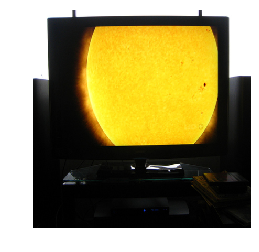

In [11]:
%matplotlib inline
myimshow(val_set[0][0])

## NETWORK ARCHITECTURE

In [12]:
import nntools as nt

In [13]:
class NNDetector(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNDetector, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

In [14]:
class DnCNN(NNDetector):
    
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        self.conv.append(nn.Conv2d(3, C, 3, padding=1)) # Padding = (3-1)/2 ==> 1
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
        # TO BE COMPLETED LATER IN QUESTION 7
   
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            h = F.relu(self.conv[k+1](h))
        y = self.conv[D+1](h) + x
        return y